In [335]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

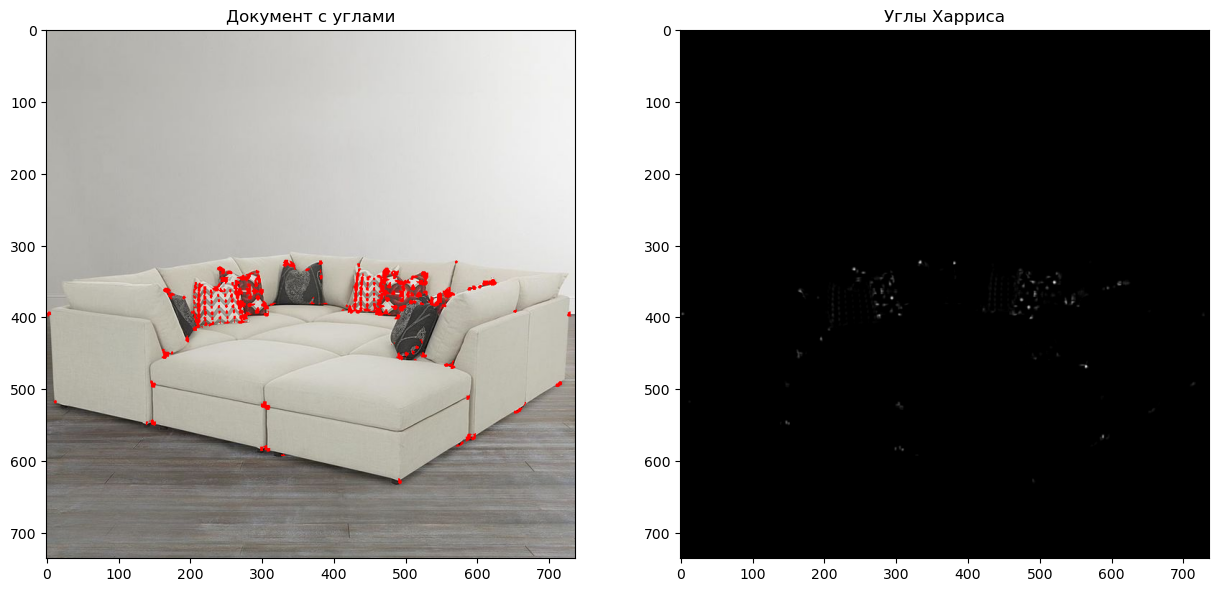

In [336]:
# Чтение изображения

# img = cv2.imread('img/document.jpg')
img = cv2.imread('img/sofa.jpg')

# Преобразование изображения в оттенки серого
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Применение размытия для удаления мелких деталей (Пробовал для другого изображения с текстом)
# gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

# Применение детектора углов Харриса
gray_float = np.float32(gray_blur)
cornerness = cv2.cornerHarris(gray_float, blockSize=5, ksize=3, k=0.04)

# Применение порогового значения для исключения мелких углов
threshold = 0.01 * cornerness.max()  # Увеличиваем пороговое значение
#Изменив это значение на +- 0.05 мы уберем лишюю детекцию углов на подушках (в том числе и орнаментов на них), но часть все равно останется


cornerness[cornerness < threshold] = 0

# Визуализация углов на изображении
img[cornerness > threshold] = [0, 0, 255]  # Отображаем углы красным цветом

# Отображение результатов
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Документ с углами')
plt.subplot(122), plt.imshow(cornerness, cmap='gray'), plt.title('Углы Харриса')
plt.show()

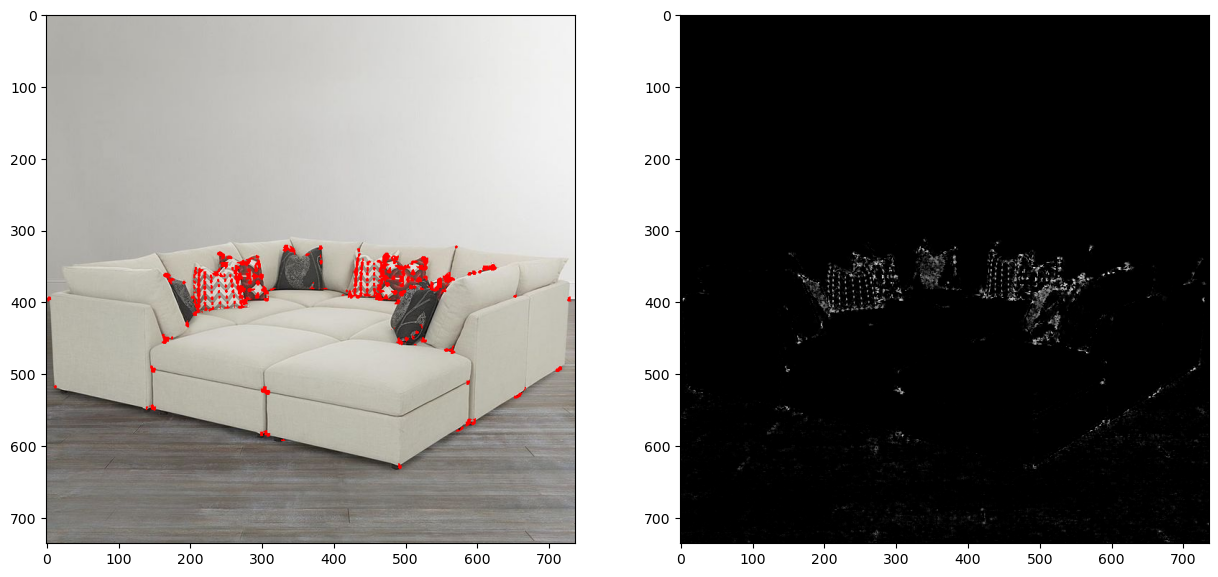

In [337]:
# Параметры для детектора углов Харриса
block_size = 2
ksize = 3
k = 0.04

# Вычисление углов Харриса
cornerness = cv2.cornerHarris(gray, block_size, ksize, k)

# Присвоение нулевых значений всем отрицательным значением уголков
cornerness[cornerness < 0] = 0

# Логарифмирование для улучшения визуализации
cornerness = np.log(cornerness + 1e-6)

# Отображение изображения и его карты углов
plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(122), plt.imshow(cornerness, cmap='gray')
plt.show()


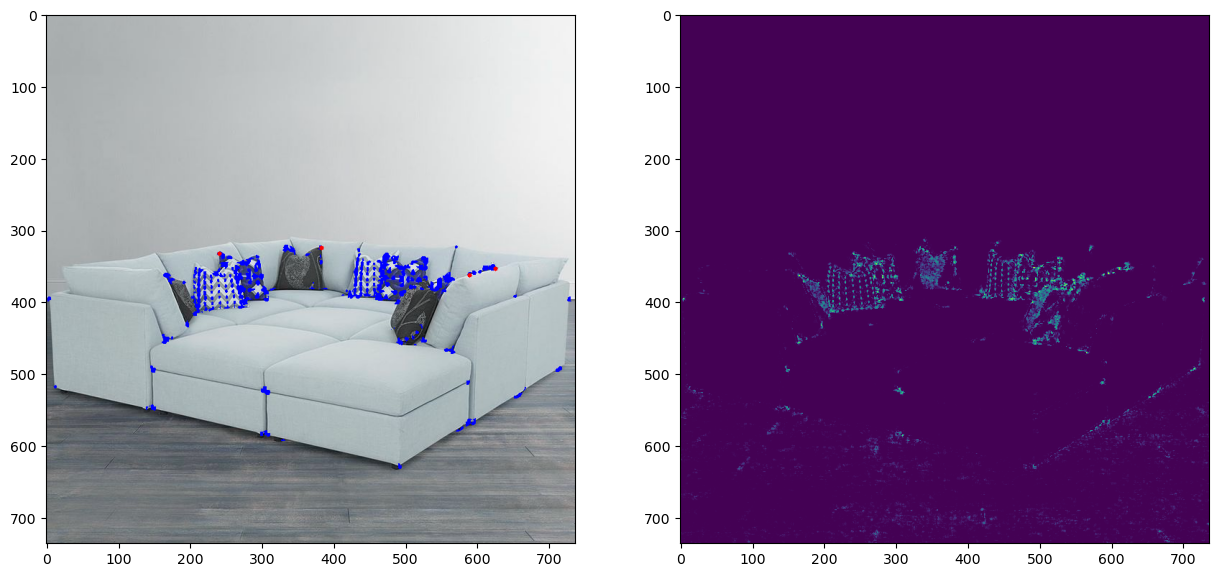

In [338]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Преобразование изображения в градации серого
rows, cols = gray.shape  # Получение размеров изображения

# Инициализация порогов для каждого угла
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Инициализация координат для каждого угла
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_right = None, None

# Размер каждого квадранта (в пикселях)
quad_size = 7

# Проход по результатам детектора Харриса
for r in range(quad_size, rows - quad_size):
    for c in range(quad_size, cols - quad_size):
        # Исключение точек с низким "угловым" значением
        if cornerness[r, c] < -7:
            continue
        
        # Извлечение блока из 4 квадрантов
        if r + quad_size + 1 > rows or c + quad_size + 1 > cols:
            continue  # Пропустить, если блок выходит за границы изображения

        block = 255 * gray[r - quad_size:r + quad_size + 1, c - quad_size:c + quad_size + 1]
        
        # Извлечение четырех квадрантов
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, quad_size + 1:2 * quad_size + 1]
        quad_bottom_left = block[quad_size + 1:2 * quad_size + 1, 0:quad_size]
        quad_bottom_right = block[quad_size + 1:2 * quad_size + 1, quad_size + 1:2 * quad_size + 1]
        
        # Верхний левый угол
        descriptor_top_left = (np.mean(quad_bottom_right) - np.mean(quad_top_left) - 
                               np.mean(quad_top_right) - np.mean(quad_bottom_left))
        if descriptor_top_left > th_top_left:
            th_top_left = descriptor_top_left
            opt_top_left = (c, r)
        
        # Верхний правый угол
        descriptor_top_right = (np.mean(quad_bottom_left) - np.mean(quad_top_right) - 
                                np.mean(quad_top_left) - np.mean(quad_bottom_right))
        if descriptor_top_right > th_top_right:
            th_top_right = descriptor_top_right
            opt_top_right = (c, r)

        # Нижний левый угол
        descriptor_bottom_left = (np.mean(quad_top_right) - np.mean(quad_bottom_left) - 
                                  np.mean(quad_top_left) - np.mean(quad_bottom_right))
        if descriptor_bottom_left > th_bottom_left:
            th_bottom_left = descriptor_bottom_left
            opt_bottom_left = (c, r)

        # Нижний правый угол
        descriptor_bottom_right = (np.mean(quad_top_left) - np.mean(quad_bottom_right) - 
                                   np.mean(quad_bottom_left) - np.mean(quad_top_right))
        if descriptor_bottom_right > th_bottom_right:
            th_bottom_right = descriptor_bottom_right
            opt_bottom_right = (c, r)

# Нарисуем круги на найденных углах
if opt_top_left:
    out = cv2.circle(img, opt_top_left, 3, (255, 0, 0), -1)
if opt_top_right:
    out = cv2.circle(img, opt_top_right, 3, (255, 0, 0), -1)
if opt_bottom_left:
    out = cv2.circle(img, opt_bottom_left, 3, (255, 0, 0), -1)
if opt_bottom_right:
    out = cv2.circle(img, opt_bottom_right, 3, (255, 0, 0), -1)

# Отображаем изображение с найденными углами
plt.subplot(121), plt.imshow(out)
plt.subplot(122), plt.imshow(cornerness)
plt.show()


## Questions

* ### Влияет ли разрешение камеры на результат? Если да, то как?

Да, разрешение камеры влияет на результат. При более высоком разрешении каждый элемент изображения становится более чётким, более детализированным. Это значит, что углы и другие особенности будут распознаваться с большей точностью, но также появится больше мелких деталей, которые могут мешать детекции. Например, если у нас 12Mpx камера, то изображение будет гораздо более чётким, чем с 1Mpx камерой, и Harris Corner Detector может начать замечать не только нужные нам углы документа, но и кучу мелких деталей, которые могут оказаться "шумом". То есть с повышением разрешения возрастает шанс того, что детектор найдёт много лишних углов, которые придётся как-то отфильтровывать.

* ### Если мы увеличим разрешение камеры, что нужно изменить в алгоритме?

Во-первых, можно увеличить размеры блоков (например, в функции cornerHarris), потому что в большом изображении каждый угол будет занимать больше пикселей. Это поможет фильтровать мелкие детали и сосредоточиться на более крупных, как вот углы документа или дивана, как у меня в примере. Во-вторых, можно увеличить пороговые значения (те, которые мы используем для фильтрации), чтобы избавиться от "мелкого" шума. И, возможно, стоит дополнительно усреднять или сглаживать изображение, чтобы снизить влияние лишних мелких объектов.
